In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import my_scripts.WiSe as WiSe
import matplotlib.pyplot as plt
import my_scripts.data_cleaning as dc
import my_scripts.TabNet_trainer as tn
import my_scripts.XGBoost_trainer as xg
import my_scripts.RidgeRegression_trainer as rr

# 2. Predictions

## A. Feature Selection

In [2]:
df = pd.read_csv('customer_data.csv')
df = df.drop(columns=['Customer', 'Effective To Date'])
target = 'Response'
df[target] = df[target].apply(lambda x: 0 if x == 'No' else 1)

def prepare_data(df):  

    # take care of non-value 
    df = df.dropna(how='any')
    df = df.reset_index(drop=True)
    
    # ordinal encoding 
    for non_numerical_feature_name in dc.non_numerical_features(df):
        dc.feature_ordinalEncoding(df, non_numerical_feature_name, inplace=True)
    return df

df = prepare_data(df)

In [3]:
# apply univariate selection filters 
selected_pearson = WiSe.univariate_filter_spearman(df, target)
selected_spearman = WiSe.univariate_filter_spearman(df, target)
selected_univariate = list(set.union(set(selected_pearson), set(selected_spearman)))

# model selection based filtering 
selected_lasso = WiSe.model_selection_lasso(df, target, selected_univariate)
print("Remaining number of features: ", len(selected_lasso), "out of", df.shape[1] -1)

Remaining number of features:  7 out of 21


## B. Ridge Regression Predictions

Accuracy: 0.86
MCC Score: 0.27
F1 Score: 0.17


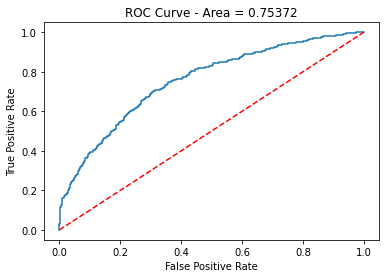

In [27]:
# trainer definition
RidgeRegression_full = rr.RidgeRegression_classifer_trainer(df, target, std=False, power_trans=True)

# hyper-params. definiton
learning_rates = [0.001, 0.01, 0.1, 0.5]
degrees = [1, 2, 3, 5]
n_components=[5, 6, 10, 12, 15, 17, 20]

# model training 
RidgeRegression_full.train_model_on_best_params(learning_rates=learning_rates, degrees=degrees, 
                                                n_components=n_components, end_evaluation=True)

**Observations:** problem with class distribution (the 'No' class is over represented compated to the 'Yes' class). The Ridge Regression Trainer doesn't include yet weight distribution or particular loss encoding to battle weight distribution problem. 

# C. TabNet Predictions

Stop training because you reached max_epochs = 100 with best_epoch = 86 and best_valid_auc = 0.83873
Best weights from best epoch are automatically used!
Accuracy: 0.86
MCC Score: 0.15
F1 Score: 0.11


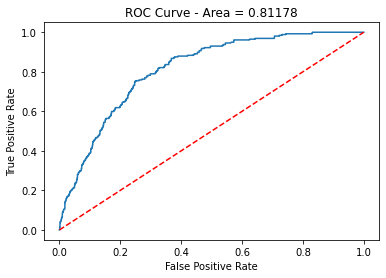

In [12]:
TabNet_full = tn.TabNet_binary_classifer_trainer(df, target, n_d=15, n_a=15, lr=0.1, lambda_sparse=1e-5)
TabNet_full.train_model(max_epochs=100, end_evaluation=True, verbose=0)

**Observations:** a simple TabNet on the entire dataset slightly outperforms Ridge Regression. Still, problem with class distribution. We will try to augment ROC curve at the expense of accuracy. 

Stop training because you reached max_epochs = 100 with best_epoch = 92 and best_valid_auc = 0.85245
Best weights from best epoch are automatically used!
Accuracy: 0.76
MCC Score: 0.42
F1 Score: 0.51


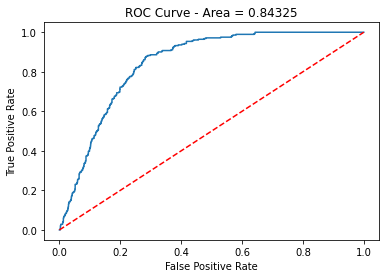

In [13]:
TabNet_balance = tn.TabNet_binary_classifer_trainer(df, target, n_d=15, n_a=15, lr=0.1, lambda_sparse=1e-5)
TabNet_balance.train_model(max_epochs=100, end_evaluation=True, verbose=0, weights=1)

Stop training because you reached max_epochs = 100 with best_epoch = 93 and best_valid_auc = 0.99147
Best weights from best epoch are automatically used!
Accuracy: 0.95
MCC Score: 0.85
F1 Score: 0.87


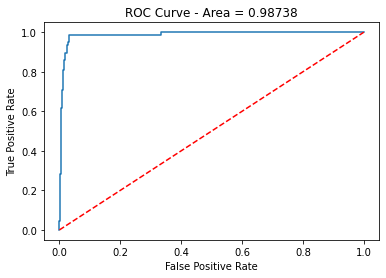

In [14]:
TabNet_balance.train_model(max_epochs=100, end_evaluation=True, verbose=0, weights=1)

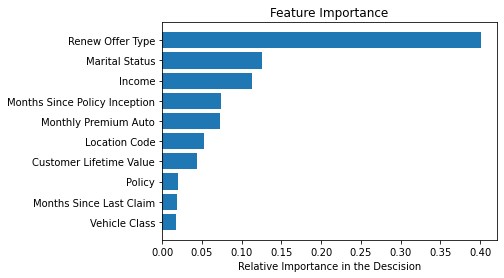

In [11]:
TabNet_balance.print_feature_importance()

**Observations:** with inverse frequency sampling, ROC curve looks great. No issue in the training.


Early stopping occurred at epoch 84 with best_epoch = 34 and best_valid_auc = 0.76934
Best weights from best epoch are automatically used!
Accuracy: 0.62
MCC Score: 0.29
F1 Score: 0.38


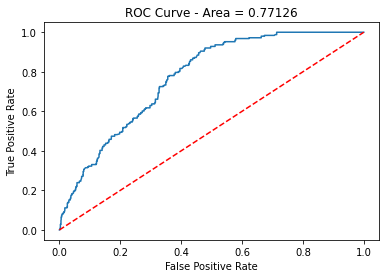

In [44]:
TabNet_WiSe = tn.TabNet_binary_classifer_trainer(df, target, n_d=8, n_a=9, lr=0.1, lambda_sparse=1e-5)
TabNet_WiSe.train_model(max_epochs=100, end_evaluation=True, verbose=0, features=selected_lasso, weights=1)

**Observations:** TabNet on reduced number of feature has worst performance than before, which is expected, we passed from 22 to 8 features, reduction was far too tight. 

Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_valid_auc = 0.7935
Best weights from best epoch are automatically used!
Accuracy: 0.87
MCC Score: 0.07
F1 Score: 0.02


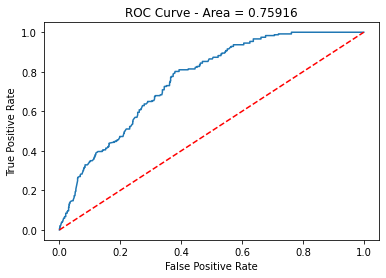

In [45]:
TabNet_WiSe = tn.TabNet_binary_classifer_trainer(df, target, n_d=8, n_a=9, lr=0.1, lambda_sparse=1e-5)
TabNet_WiSe.train_model(max_epochs=100, end_evaluation=True, verbose=0, features=selected_lasso, weights=0)

## D. XGBoost Predictions

Best CV min score: 0.95
Accuracy: 0.97
MCC Score: 0.89
F1 Score: 0.91


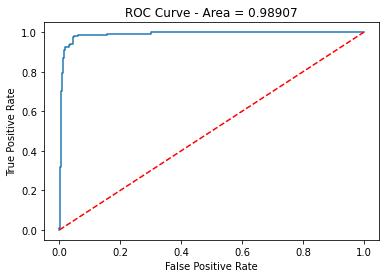

In [6]:
# trainer definiton
XGBoost_full = xg.XGBoost_classifier_trainer(df, target)

# hyper-params def. 
max_depths = [1, 2, 4, 5, 8, 10]
learning_rates = [0.001, 0.01, 0.1, 0.7]
n_estimators = [2, 3, 5, 7]

# model training
XGBoost_full.train_model_on_best_params(max_depths=max_depths, learning_rates=learning_rates, 
                                        n_estimators=n_estimators, end_evaluation=True)

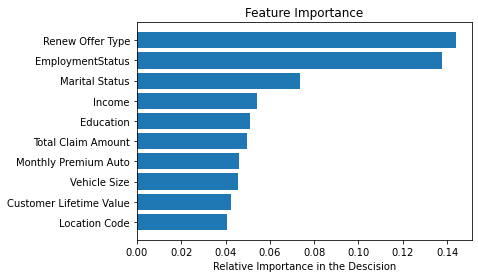

In [7]:
XGBoost_full.print_feature_importance()

**Observations:** XGBoost gives instant great results, which leads to think that the example was tailored with XGBoost in mind ... 